In [25]:
from solana.rpc.api import Client
from solana.rpc.types import TokenAccountOpts
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import requests
import time
import json
import sys
import os

# Theme
from jupyterthemes import jtplot
jtplot.style(theme='chesterish', context='notebook', ticks=True, grid=False)

# User libraries
from Token import *
from factions import *
from players import *
from nfts import *

### Faction configuration
- Faction 0 = MUD
- Faction 1 = ONI
- Faction 2 = USTUR

In [26]:
FACTIONS = [
    'MUD',
    'ONI',
    'USTUR',
]
# MUD = 0
# ONI = 1
# USTUR = 2
LOAD_FROM_FILES = False

#### General DataFrames

In [27]:
FACTIONS_INVENTORY_DF = pd.DataFrame()

#### Functions

In [28]:
# Wallet balance getter
client = Client("https://api.mainnet-beta.solana.com")
def get_balance(wallet):
    tokens = client.get_token_accounts_by_owner(
        wallet, 
        TokenAccountOpts(program_id='TokenkegQfeZyiNwAJbNbGKPFXCWuBvf9Ss623VQ5DA', encoding='jsonParsed')
    )
    return tokens_from_dict(tokens)

# Get players balances
def get_players_balances(player_list):
    data = []
    for i, player in enumerate(player_list):
        try:
            results = get_balance(player.public_key)
            atlas = 0
            polis = 0
            for value in results.result.value:
                if 'atlas' in value.account.data.parsed.info.mint.lower(): 
                    atlas = value.account.data.parsed.info.token_amount.ui_amount
                if 'polis' in value.account.data.parsed.info.mint.lower(): 
                    polis = value.account.data.parsed.info.token_amount.ui_amount
            print(f"Current wallet: {player.public_key}, {i+1} of {len(player_list)}; Balance: A {atlas}, P {polis}")
            data_to_append = {
                    'Faction' : FACTIONS[player.faction],
                    'Wallet': player.public_key,
                    "Atlas": atlas,
                    "Polis":polis,
                    "NFTS": player.balances,
                    "NFT_sum_usdc": player.balance,
                }
            data.append(data_to_append)
        except:
            print(f"Error in {i+1} of {len(player_list)}")
        time.sleep(2)
    return pd.DataFrame(data=data)

# convert str back to a class
def str_to_class(classname):
    return getattr(sys.modules[__name__], classname)

### Create dataframe (if not exists csv)

In [29]:
if not os.path.exists('./leaderboard-data.csv'):
    data = {
        'Faction' : [float('NaN')],
        'Wallet': [float('NaN')],
        "Atlas": [float('NaN')],
        "Polis": [float('NaN')],
        "NFTS": [float('NaN')],
        "NFT_sum_usdc": [float('NaN')],
    }
    DF = pd.DataFrame(data=data)
else:
    DF = pd.read_csv('./leaderboard-data.csv', index_col=False)
DF.head()

,Faction,Wallet,Atlas,Polis,NFTS,NFT_sum_usdc
0,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
player_amount = 600
player_amount_already_collected = 0
player_per_page = 50
players_list = []
if not LOAD_FROM_FILES:
    # requests
    for i in range(int(player_amount_already_collected / player_per_page), int( player_amount / player_per_page)):
        players_request = requests.get(f"https://galaxy.staratlas.com/leaderboards/players/?page={i}")
        # Get player list
        obj = players_from_dict(json.loads(players_request.text))
        players_list += obj
    Players_DataFrame = pd.DataFrame(players_list)
    Players_DataFrame.to_csv('./players.csv', index=False)
    print(len(players_list))

550


In [31]:
# request
factions_request = requests.get("https://galaxy.staratlas.com/leaderboards/factions")
# Get faction list
factions_list = factions_from_dict(json.loads(factions_request.text))

In [32]:
# GET nfts list
nfts_request = requests.get('https://galaxy.staratlas.com/nfts')
nfts_list = nfts_from_dict(json.loads(nfts_request.text))

In [33]:
NFTS_DF = pd.DataFrame(nfts_list)
NFTS_DF[['name', 'mint']]

,name,mint
0,Discovery of Iris,HAWy8kV3bD4gaN6yy6iK2619x2dyzLUBj1PfJiihTisE
1,The Heart of Star Atlas,ATSPo9f9TJ3Atx8SuoTYdzSMh4ctQBzYzDiNukQDmoF7
2,The Convergence War,36s6AFRXzE9KVdUyoJQ5y6mwxXw21LawYqqwNiQUMD8s
3,Short Story of a Lost Astronaut,BgiTVxW9uLuHHoafTd2qjYB5xjCc5Y1EnUuYNfmTwhvp
4,B ❤ P,4G85c5aUsRTrRPqE5VjY7ebD9b2ktTF6NEVGiCddRBDX
...,...,...
78,TTT 300K THE_FAB_RIC_ANT,6pUxjPghGz5Gn9XnJuPaJCSpk9mhvzecvHb6G4rrSCJq
79,Pearce F4,9MvZS3TVfv4DZL9W2pT12po384aBHf7wi89KXQ9Z7uwW
80,Fimbul ECOS Greenader,FpwV1Da6BZJnYPr1JSLUm14UwBmZHA7J5WLY4TXgbde8
81,Sammy Banx,BswdGxfurGpSKPPhHUP6d9uzdY3bAG8o3CJnFUQLanzw


In [34]:
if LOAD_FROM_FILES:
    players_balances = pd.read_csv('./Playerbalances.csv')
else:
    print('Starting data download')
    # Get players balances
    players_balances = get_players_balances(players_list)
players_balances.head()

Starting data download
Current wallet: G3YpYsexKbYNCbVdufR2LMcc6v12zPLtHAk51yG9GcEv, 1 of 550; Balance: A 514.56144741, P 6.52964333
Current wallet: GnMgJTn9iQf7LaHGy1VKPwhQ196WbTviGnovSHypQJeu, 2 of 550; Balance: A 200000.6116271, P 2500.62075877
Current wallet: 7BajRMkuo8gDoykSvieeNJF6vuH5MgfAzvne3CtFtvRM, 3 of 550; Balance: A 771086.96637681, P 11834.45605742
Current wallet: L7y4zXUS1f6SuPynJYb4XBhi7YS635eVbh1WaHsn2hE, 4 of 550; Balance: A 489996.93642288, P 5285.77598747
Current wallet: 9PGjxWhx5iARoTz6gwDmDBStFoDq591nCHBRXqXcej2d, 5 of 550; Balance: A 0.00503966, P 0.00911439
Current wallet: kvCSg25w3sKi3MbuxhGnyLPRqCnNPuqzYisQ2mm6DYN, 6 of 550; Balance: A 2000038.61317626, P 30296.68244963
Current wallet: GRfYDJMLWUwpvZXFxDSEuwzMamffbyqPDQBadMBtFakA, 7 of 550; Balance: A 9000.0, P 0.0
Current wallet: DnBSTyLkxsngyEV5hT2xk4MGxaYdHrZ398KW4t81ac26, 8 of 550; Balance: A 77162.13186732, P 1104.6885168
Current wallet: 52PeackCAWPAg8oYYoMbRvCuyvuBGxSKLuAH4439oj11, 9 of 550; Balance: A 0

Current wallet: Hdn3HDgoPE4jTFKTqifHreyZZooWz7Pr6Ywz1K3oatcv, 81 of 550; Balance: A 4934.81706079, P 80.70685637
Current wallet: 9fmWUCiKMbqnna6uhJ8X1xVVB5gXKxKUjDw32nGsGKqL, 82 of 550; Balance: A 47251.26891923, P 4986.16520233
Current wallet: BPPt5uXqXWcpAZrzN7ANKmTkTtGMH3fxYPArxPGXBvyt, 83 of 550; Balance: A 0, P 0
Current wallet: Cqotc2shq1vftHHq6GkVpRbQ74ktNR12TuVP4LSPaard, 84 of 550; Balance: A 254.94389401, P 5.0
Current wallet: GBwK43y54hWGs4TCwUC3JQ2puxrVoFdLBMFG5qvnjzSW, 85 of 550; Balance: A 0.0, P 0.0
Current wallet: 9AvGe8V45ufxcPKaZLBiC1wBVMSfowgppjxmpDFgWNRy, 86 of 550; Balance: A 450.54931913, P 0.0
Current wallet: JEJwV4wZxZdusbW5XZdY2ZxNJbgevXovRJHL9iJiNpn, 87 of 550; Balance: A 0.0, P 0.0
Current wallet: E5tCYDoZkUeftxyjTP9HZrWwLbNKAbBgWDWsTthq2awS, 88 of 550; Balance: A 0, P 0.0
Current wallet: 2j8Dcw2pwDrCQgcgeYWQFXDg3tj9mdQYSXvPH63bgeeH, 89 of 550; Balance: A 36333.31965439, P 944.70925162
Current wallet: 9duN9u7Y16qRBaBfVbEeabXdjZdwHCAmd5Lj9FPd276b, 90 of 550; Ba

Current wallet: AWdCKjMDjL72onw3VT9fa1aft96pVrM4GRBRfs4mXm5c, 163 of 550; Balance: A 0, P 0
Current wallet: AXPtxi2T7fxQZgMKdsRztFzP9nFcgNbeCogAxZVhfkUC, 164 of 550; Balance: A 2.14e-06, P 48.1242348
Current wallet: CxxMwsbtDCLwpqpZA6SWDqt2Vusy1zCae3wAo2soVuC6, 165 of 550; Balance: A 2732.1839637, P 184.44180492
Current wallet: Dhx5233ZX8QXr37iRakowgrEnWFN1hDfcibUqyqxRWwu, 166 of 550; Balance: A 12951.38342337, P 156.69290769
Current wallet: EoChTP7gPpjZP1n2CXn8VrPxdk187Se6iVjqwqRPLxAw, 167 of 550; Balance: A 0.0, P 0.0
Current wallet: 6zpVor3ASXWftDWjtmUPZPT7k9xh6yD78GBLvh3QqvSx, 168 of 550; Balance: A 0, P 0
Current wallet: 3ewy8krwPiLedfyYcQk68nVjM2b489n9srLp7XPcXMhn, 169 of 550; Balance: A 1687.95562389, P 0.33061432
Current wallet: 8sQzUoiFfBUsfVKdUjUh3xUjwnaCP1Qmw9BGwtH768ZR, 170 of 550; Balance: A 0.0, P 0.0
Current wallet: 3uTDFUDQjEDJHtnPxLDR52tR1Mv2F4YNJ6pMKznQNuYj, 171 of 550; Balance: A 20443.84369493, P 0.0
Current wallet: 2H5YW5n9phX3mB5dJBwj2UsyjMQ7LvEpgj9F8Sf3bDLT, 172 

Current wallet: HgBWT44ooNtGsRhGyxfTdWGD5i75ajHPdgsSj6akSwDM, 244 of 550; Balance: A 0.0, P 0.0
Current wallet: uuuUspidwGcTmw58Db61HnEM8jNFTrqqEWHw2ubAu5T, 245 of 550; Balance: A 0.0, P 0.0
Current wallet: 9Rneu6NRWuHhox77Uc7bo1utwZjGk5cAEKQntcJC6Hkj, 246 of 550; Balance: A 7555.3408646, P 74.35348259
Current wallet: 4yTXqmm9m8WNJLzVu9mRxBPXXMY6wkAbzBYvwjAU3ZDt, 247 of 550; Balance: A 7109.84340388, P 0.0
Current wallet: Dc5aZE3MxBQfsqx7SvSRXn2Ki4n4g4VMywBVHaodbNs6, 248 of 550; Balance: A 0.0, P 0
Current wallet: DUiNooTwfUacjGNoUfCZnFYqrFBLdhtBB4zbByKT6FfN, 249 of 550; Balance: A 0, P 0
Current wallet: Fum55Vkbhqna2WKTG1vdt69Vxe23kFTjQ2eEXzXA2iBn, 250 of 550; Balance: A 20775.995835, P 0.0
Current wallet: 2PRcpTjgd86M2Lwb6DVBD8TPv79VaYGPLnBZjzSuPp8u, 251 of 550; Balance: A 67122.14733843, P 309.25637304
Current wallet: 2KGpvsGWPmdKUQVXMUFnMy6mdUwt4hK2oHQGUE8pV13y, 252 of 550; Balance: A 787.6, P 0.0
Current wallet: 5UEMbfkgvoF6YaVjh3iTqd5U5cTEVw15QLpUSuqBRU8Y, 253 of 550; Balance: A 

Current wallet: LvHfiGGGU7hLHCUgpfLWff6VD3U7Bkh7PHJHesMFgu1, 325 of 550; Balance: A 0.1282281, P 0.00138337
Current wallet: 7Pe11CYmLJKbhjK9xjfk5xyNWtmkx3EGBUfedqUYtJso, 326 of 550; Balance: A 0.0, P 0.0
Current wallet: 7iprXWduUW5gSnCjszuDGoxoXXUHc8MNnjMCgdXLbsiU, 327 of 550; Balance: A 46441.32445874, P 1026.74549808
Current wallet: 3PBTvfmrjgUFzggjbGPogSf5N5Mivr3Z23FMaFvrNRf7, 328 of 550; Balance: A 0, P 13.15717958
Current wallet: 3x2JVoT5wNSzDrTD1o2No9WtKxvBxqEiQeMwAv3LGvqz, 329 of 550; Balance: A 10804.87943717, P 410.14066138
Current wallet: ARbRdAEBm3jCGoBKeAmmnJJJ5UmKhx31b1HMK3G8DLYi, 330 of 550; Balance: A 10470.57988424, P 345.10733633
Current wallet: J6233KPqWoRQY459yxbYByUc7W83TdF5AMrVfVpN6ib2, 331 of 550; Balance: A 0, P 0.0
Current wallet: 4mFb3ngR37NejLEm1SQkS6Hp88dfvYqQvWcX9ezLhqB2, 332 of 550; Balance: A 10000.00028986, P 186.5942029
Current wallet: 13EWffGYyBdPCnquG4Yqu92hvCQ6Lp7Ua1jeuYp2mRj6, 333 of 550; Balance: A 74782.6, P 1247.8
Current wallet: Frv38fBuWFzz8HNJC

Current wallet: 4tXXER5MrP1FdrgbDxCf3xJmpicdjGBfNfTBBQoFXNDn, 407 of 550; Balance: A 0.0, P 588.0530403
Current wallet: BSQtvgJC44wCRhdwNJrkSV77Svb8KBDkAQdnWntLNrt4, 408 of 550; Balance: A 0.0, P 0.0
Current wallet: GryCY2q2uSJEL783nW9w48rXb4x9q9irFsLAqaPzkmWb, 409 of 550; Balance: A 5.24913113, P 0.05839516
Current wallet: 5abJmqcRn8KrtpL85g7ngLdphagkgw7A9m8mr77mkiRn, 410 of 550; Balance: A 159.42028986, P 1.5942029
Current wallet: 5VfgFs8V1qfM7pJhov3rMzAM1E7JGC6DNAEQmxTxsDRL, 411 of 550; Balance: A 5058.17464379, P 26.40193964
Current wallet: AikN3AXdivCan3aiX3m9qKwn8qx1vdWNLA8oTdDzG15T, 412 of 550; Balance: A 0.0, P 2.0073725
Current wallet: 225cuveEgYgeE4gqsSY1nkae8WAUruU9QC5Ld53G3s2C, 413 of 550; Balance: A 0.0, P 0.0
Current wallet: 4xC2g6e3jjdDAhZRv4qJxoBrKhuxCEMsTrHpVaS75Wsq, 414 of 550; Balance: A 0.0, P 0.0
Current wallet: AnxKwEaUJGXGvNgMBBzqCZev4cG8uPJ6W82wrWcGBRgq, 415 of 550; Balance: A 0.0, P 0.0
Current wallet: CcoBXF3qbTToppexNZrLvNpwozj7Sw3RHDxsLoGsGbfb, 416 of 550; B

Current wallet: 6gYeaEULEH6f6Pu1SpcgnENUonKegjGa8f6GWwreyqQt, 489 of 550; Balance: A 0.0, P 0.0
Current wallet: ChGf3ASdqkvtvTtdGXqGFDEDTUKnWoePTr2r6UXyUpKM, 490 of 550; Balance: A 0, P 900.60719577
Current wallet: GcBYh3EXguYPCyH2PvgVJLwkaW5snhFSMUukS64AkB5f, 491 of 550; Balance: A 10966.06567568, P 208.98493894
Current wallet: E49Vk1xHwzdWPwEs4Dw1wtcQjeSR3Sw9HNihmsfz9q4k, 492 of 550; Balance: A 0.0, P 2.73880538
Current wallet: BUxkPkbXkPBBGw6wdnNnYuoJhVhsUwcSEFNZtn6Vaxbh, 493 of 550; Balance: A 0.0, P 0.0
Current wallet: D8DY43awCjufTxzaZLRocvvwF9ifviU16b8kPaFnBQGn, 494 of 550; Balance: A 4442.22514204, P 546.03705296
Current wallet: DKvkBoLfnvvQ642V1vkmLtpEAUMMvG8amucdqwqnAYZi, 495 of 550; Balance: A 0.0, P 50.79329168
Current wallet: 64vB6r7rXcYuC3ffaCCAhZKjtgiyS5hHMqVf2baGCxdG, 496 of 550; Balance: A 7689.5, P 5.9994923
Current wallet: 4p1XahShpV4H51z8uzB5zxfXR5o3cDs5JvVcx2JJ7Qcz, 497 of 550; Balance: A 9498.67427456, P 0.04006561
Current wallet: BJRmtMdjZqg4tbNj7ZHUYtvimXVZ4qbM7

,Faction,Wallet,Atlas,Polis,NFTS,NFT_sum_usdc
0,ONI,G3YpYsexKbYNCbVdufR2LMcc6v12zPLtHAk51yG9GcEv,514.561447,6.529643,"[Balance(id='6160bfa408e62f00131e959c', mint='...",922660
1,USTUR,GnMgJTn9iQf7LaHGy1VKPwhQ196WbTviGnovSHypQJeu,200000.611627,2500.620759,"[Balance(id='6160bfa408e62f00131e95bb', mint='...",324360
2,USTUR,7BajRMkuo8gDoykSvieeNJF6vuH5MgfAzvne3CtFtvRM,771086.966377,11834.456057,"[Balance(id='6160bfa408e62f00131e95f5', mint='...",304983
3,ONI,L7y4zXUS1f6SuPynJYb4XBhi7YS635eVbh1WaHsn2hE,489996.936423,5285.775987,"[Balance(id='6160bfa408e62f00131e962b', mint='...",256687
4,USTUR,9PGjxWhx5iARoTz6gwDmDBStFoDq591nCHBRXqXcej2d,0.005040,0.009114,"[Balance(id='6160bfa408e62f00131e966e', mint='...",250525


In [45]:
# merge results with total DF
# merge only if wallet not existis
players_balances_bkp = players_balances
players_balances_bkp.to_csv('./Playerbalances.csv', index=False)
columns = list(DF.columns) # get DF columns
DF = DF.loc[players_balances.Wallet.isin(DF.Wallet)] = players_balances[columns] # update old values
# remove values alreary in DF
# players_balances.drop(index=players_balances.Wallet.isin(DF.Wallet).index) 
DF = DF.append(players_balances, ignore_index=True) # append new values
DF = DF.drop_duplicates(subset=['Wallet']) # remove duplicates
# DF.head()
# Save DF
DF.to_csv('./leaderboard-data.csv', index=False)
DF.head()

,Faction,Wallet,Atlas,Polis,NFTS,NFT_sum_usdc
0,ONI,G3YpYsexKbYNCbVdufR2LMcc6v12zPLtHAk51yG9GcEv,514.561447,6.529643,"[Balance(id='6160bfa408e62f00131e959c', mint='...",922660
1,USTUR,GnMgJTn9iQf7LaHGy1VKPwhQ196WbTviGnovSHypQJeu,200000.611627,2500.620759,"[Balance(id='6160bfa408e62f00131e95bb', mint='...",324360
2,USTUR,7BajRMkuo8gDoykSvieeNJF6vuH5MgfAzvne3CtFtvRM,771086.966377,11834.456057,"[Balance(id='6160bfa408e62f00131e95f5', mint='...",304983
3,ONI,L7y4zXUS1f6SuPynJYb4XBhi7YS635eVbh1WaHsn2hE,489996.936423,5285.775987,"[Balance(id='6160bfa408e62f00131e962b', mint='...",256687
4,USTUR,9PGjxWhx5iARoTz6gwDmDBStFoDq591nCHBRXqXcej2d,0.005040,0.009114,"[Balance(id='6160bfa408e62f00131e966e', mint='...",250525


In [35]:
FACTIONS_INVENTORY_DF['faction name'] = 'MUD'
FACTIONS_INVENTORY_DF[NFTS_DF['name']] = '-'
FACTIONS_INVENTORY_DF.loc[0] = [i for i in range(NFTS_DF['name'].size)]
FACTIONS_INVENTORY_DF.loc[1] = [i for i in range(NFTS_DF['name'].size)]
FACTIONS_INVENTORY_DF.loc[2] = [i for i in range(NFTS_DF['name'].size)]
FACTIONS_INVENTORY_DF.head()

,faction name,Discovery of Iris,The Heart of Star Atlas,The Convergence War,Short Story of a Lost Astronaut,B ❤ P,The Assassination of Paizul,Paizul Funeral Procession,Ahr Visits Earth,The Last Stand,...,TTT 300K ATLAS,TTT 300K SOLANA,TTT 300K STEP.finance,TTT 300K Phantom,PRIMORDIAL GLO,TTT 300K THE_FAB_RIC_ANT,Pearce F4,Fimbul ECOS Greenader,Sammy Banx,Anna Tolle
0,0,1,2,3,4,5,6,7,8,9,...,73,74,75,76,77,78,79,80,81,82
1,0,1,2,3,4,5,6,7,8,9,...,73,74,75,76,77,78,79,80,81,82
2,0,1,2,3,4,5,6,7,8,9,...,73,74,75,76,77,78,79,80,81,82


#### NFT Separation (Type and amount)

In [36]:
mud_nfts = players_balances.loc[players_balances['Faction'] == 'ONI']
mud_nfts.loc[mud_nfts['Wallet'] == 'G3YpYsexKbYNCbVdufR2LMcc6v12zPLtHAk51yG9GcEv']

,Faction,Wallet,Atlas,Polis,NFTS,NFT_sum_usdc
0,ONI,G3YpYsexKbYNCbVdufR2LMcc6v12zPLtHAk51yG9GcEv,514.561447,6.529643,"[Balance(id='6160bfa408e62f00131e959c', mint='...",922660


In [39]:
# MUD
mud_nfts = players_balances.loc[players_balances['Faction'] == 'MUD']['NFTS']
FACTIONS_INVENTORY_DF.at[0,'faction name'] = 'MUD'
for mud in mud_nfts:
    for value in eval(str(mud)):
         FACTIONS_INVENTORY_DF.at[0, NFTS_DF.loc[NFTS_DF['mint']== value.mint]['name'].values[0]] += value.quantity
# ONI
oni_nfts = players_balances.loc[players_balances['Faction'] == 'ONI']['NFTS']
FACTIONS_INVENTORY_DF.at[1,'faction name'] = 'ONI'
for oni in oni_nfts:
    for value in eval(str(oni)):
         FACTIONS_INVENTORY_DF.at[1, NFTS_DF.loc[NFTS_DF['mint']== value.mint]['name'].values[0]] += value.quantity
# USTUR
ustur_nfts = players_balances.loc[players_balances['Faction'] == 'USTUR']['NFTS']
FACTIONS_INVENTORY_DF.at[2,'faction name'] = 'USTUR'
for ustur in ustur_nfts:
    for value in eval(str(oni)):
         FACTIONS_INVENTORY_DF.at[2, NFTS_DF.loc[NFTS_DF['mint']== value.mint]['name'].values[0]] += value.quantity
FACTIONS_INVENTORY_DF.to_csv('./faction_inventory.csv', index=False)
FACTIONS_INVENTORY_DF.head()

,faction name,Discovery of Iris,The Heart of Star Atlas,The Convergence War,Short Story of a Lost Astronaut,B ❤ P,The Assassination of Paizul,Paizul Funeral Procession,Ahr Visits Earth,The Last Stand,...,TTT 300K ATLAS,TTT 300K SOLANA,TTT 300K STEP.finance,TTT 300K Phantom,PRIMORDIAL GLO,TTT 300K THE_FAB_RIC_ANT,Pearce F4,Fimbul ECOS Greenader,Sammy Banx,Anna Tolle
0,MUD,613,346,268,143,137,25,22,24,9,...,508,409,323,386,277,320,196,106,294,95
1,ONI,1784,808,130,64,59,14,13,14,9,...,298,298,254,336,401,260,155,95,201,88
2,USTUR,157,158,159,160,161,6,7,8,9,...,1477,1478,1479,1480,233,1482,79,80,81,82


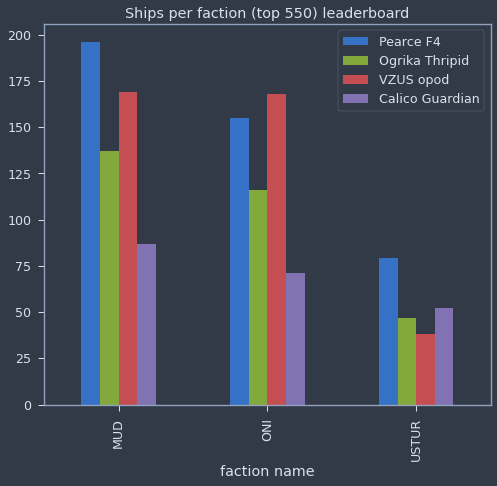

In [40]:
group = FACTIONS_INVENTORY_DF[['faction name','Pearce F4','Ogrika Thripid','VZUS opod','Calico Guardian']]
group.plot(kind='bar', x='faction name')
plt.title(f'Ships per faction (top {players_balances["Faction"].size}) leaderboard')
plt.savefig('./faction_ships.jpg')

In [46]:
DF.groupby('Faction').sum()

,Atlas,Polis,NFT_sum_usdc
Faction,,,
MUD,3.396360e+06,57355.306623,7818633
ONI,3.279180e+06,63130.142706,5146250
USTUR,5.127454e+06,112852.238328,6264544


In [47]:
DF.sort_values(by=['Polis','Atlas'])

,Faction,Wallet,Atlas,Polis,NFTS,NFT_sum_usdc
8,MUD,52PeackCAWPAg8oYYoMbRvCuyvuBGxSKLuAH4439oj11,0.000000e+00,0.000000,"[Balance(id='6160bfa508e62f00131e973d', mint='...",189886
10,MUD,C1pJTKGKDuzj7JcdqvushT2oVVZvpkRfEPSV6MmrKNLE,0.000000e+00,0.000000,"[Balance(id='6160bfa508e62f00131e97ab', mint='...",186869
12,MUD,AxEHSMaQHTBtba8VvCBm9AerpPNLx7ALUEopAxd45Q5D,0.000000e+00,0.000000,"[Balance(id='6160bfa508e62f00131e97e8', mint='...",180680
18,ONI,FaVEJtxTgenGL9mQXFjDvpQ3R7JcMF6vdrBX5Usr9vP8,0.000000e+00,0.000000,"[Balance(id='6160bfa508e62f00131e98d8', mint='...",139122
19,USTUR,B1RFDjNiRjK9Lxs34NzgcCyaEc2NfZRtXg9kn9TomeUz,0.000000e+00,0.000000,"[Balance(id='6160bfa508e62f00131e98e4', mint='...",138063
...,...,...,...,...,...,...
51,ONI,CKLECQXRkbPW8irBjhCFavGzZKzkMqrWoRNrWSj4hJuH,1.000001e+06,10000.000000,"[Balance(id='6160bfa508e62f00131e9e6b', mint='...",79250
119,ONI,9XnDVAzQ1aYMcTytomaXYpWi3YGvy14u7ZgzRptPtghN,4.306258e+04,10209.927003,"[Balance(id='6160bfa508e62f00131ea5ad', mint='...",42015
2,USTUR,7BajRMkuo8gDoykSvieeNJF6vuH5MgfAzvne3CtFtvRM,7.710870e+05,11834.456057,"[Balance(id='6160bfa408e62f00131e95f5', mint='...",304983
23,USTUR,4VoAziqQ6oKKBJyrGg9YHBe3Qxzdv7XbpUrLa2Ycxw8B,5.000000e+04,28945.269648,"[Balance(id='6160bfa508e62f00131e9975', mint='...",121377


,Wallet,Atlas,Polis,NFTS,NFT_sum_usdc
Faction,,,,,
MUD,250,250,250,250,250
ONI,144,144,144,144,144
USTUR,156,156,156,156,156


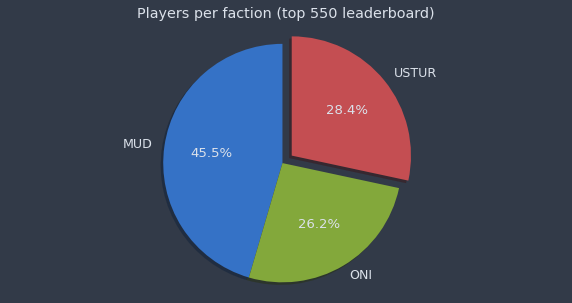

In [65]:
# count of each faction
g = DF.groupby('Faction').count()
fig1, ax1 = plt.subplots(figsize=(10, 5))
ax1.pie(
    g['Wallet'],
    explode=explode,
    labels=g.index,
    autopct='%1.1f%%',
    shadow=True,
    startangle=90
)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title(f'Players per faction (top {DF["Faction"].size} leaderboard)')
plt.savefig('./players_p_faction_leaderboard.jpg')
g.head()

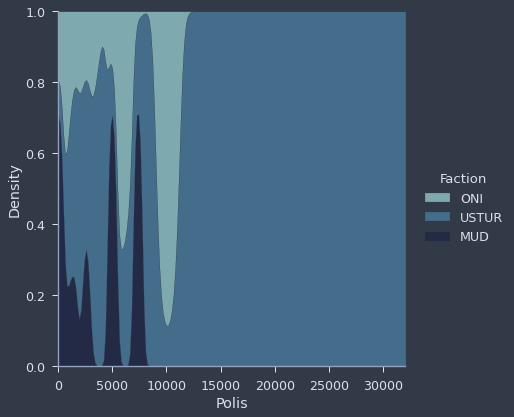

In [49]:
sns.displot(
    data=DF,
    x="Polis", hue="Faction",
    kind="kde", height=6,
    multiple="fill", clip=(0, None),
    palette="ch:rot=-.25,hue=1,light=.75",
)
plt.savefig("polis_per_faction.jpg")

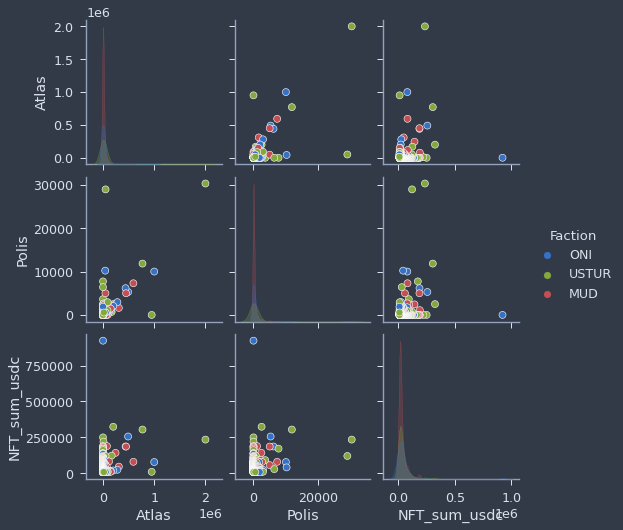

In [50]:
# Separate by Faction
MUD = DF.loc[DF['Faction'] == 'MUD']
ONI = DF.loc[DF['Faction'] == 'ONI']
USTUR = DF.loc[DF['Faction'] == 'USTUR']
sns.pairplot(DF, hue="Faction", )
plt.savefig('./pairplot_faction.jpg')

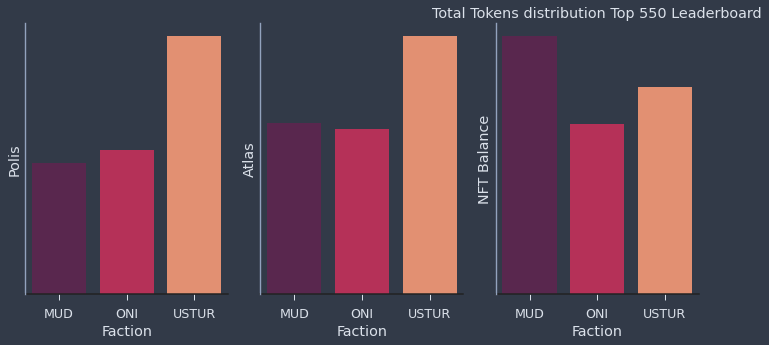

In [66]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5), sharex=False)

# Generate some sequential data
gp = DF.sort_values(by=['Atlas', 'Polis'])
gp = gp.groupby('Faction').sum()
x = gp.index
y1 = gp['Polis']
sns.barplot(x=x, y=y1, palette="rocket", ax=ax1)
ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("Polis")

# Center the data to make it diverging
y2 = gp['Atlas']
sns.barplot(x=x, y=y2, palette="rocket", ax=ax2)
ax2.axhline(0, color="k", clip_on=False)
ax2.set_ylabel("Atlas")

# Randomly reorder the data to make it qualitative
y3 = gp['NFT_sum_usdc']
sns.barplot(x=x, y=y3, palette="rocket", ax=ax3)
ax3.axhline(0, color="k", clip_on=False)
ax3.set_ylabel("NFT Balance")

# Finalize the plot
sns.despine(bottom=True)
plt.title(f"Total Tokens distribution Top {DF['Faction'].size} Leaderboard")
plt.setp(f.axes, yticks=[])
plt.tight_layout(h_pad=2)
plt.savefig('./balance_per_faction.jpg')

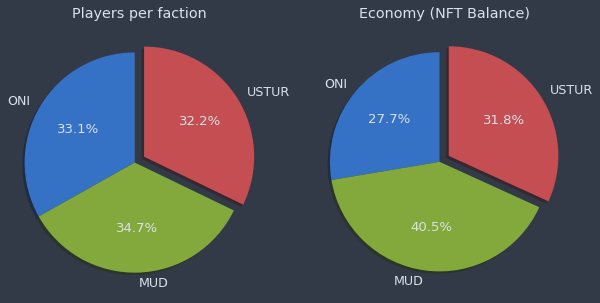

In [56]:
DF_Factions = pd.DataFrame(factions_list)
DF_Factions['faction'].replace({0:'MUD',1:'ONI',2:'USTUR'}, inplace=True)

explode = (0, 0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.pie(
    DF_Factions['total_players'],
    explode=explode,
    labels=DF_Factions['faction'],
    autopct='%1.1f%%',
    shadow=True,
    startangle=90
)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Players per faction')
DF_Factions['balance'] = [row['total'] for row in DF_Factions['value']]

ax2.pie(
    DF_Factions['balance'],
    explode=explode,
    labels=DF_Factions['faction'],
    autopct='%1.1f%%',
    shadow=True,
    startangle=90
)
ax2.set_title('Economy (NFT Balance)')
ax2.axis('equal') 

plt.savefig('./faction_share.jpg')
plt.show()


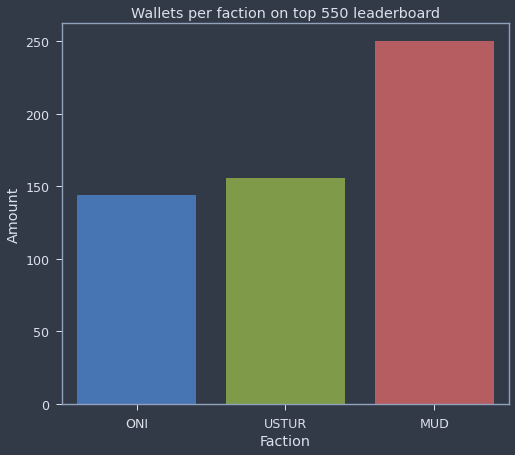

In [53]:
ax = sns.countplot(data=DF, x='Faction')
ax.set_title(f'Wallets per faction on top {DF["Faction"].size} leaderboard')
ax.set_ylabel('Amount')
plt.savefig('./wallets_per_faction.jpg')

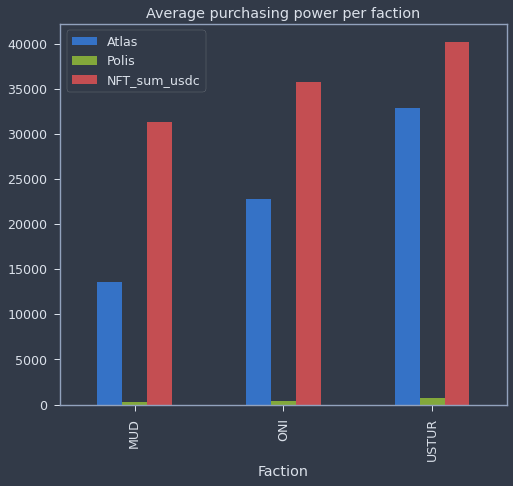

In [54]:
DF.groupby('Faction').mean().plot(kind='bar')
plt.title('Average purchasing power per faction')
plt.savefig('./average_purchasing_power.jpg')

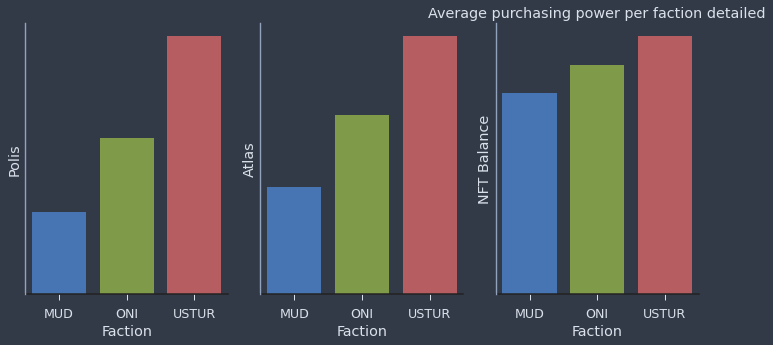

In [67]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5), sharex=False)

# Generate some sequential data
gp = DF.sort_values(by=['Atlas', 'Polis'])
gp = gp.groupby('Faction').mean()
x = gp.index
y1 = gp['Polis']
sns.barplot(x=x, y=y1, ax=ax1)
ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("Polis")

# Center the data to make it diverging
y2 = gp['Atlas']
sns.barplot(x=x, y=y2, ax=ax2)
ax2.axhline(0, color="k", clip_on=False)
ax2.set_ylabel("Atlas")

# Randomly reorder the data to make it qualitative
y3 = gp['NFT_sum_usdc']
sns.barplot(x=x, y=y3, ax=ax3)
ax3.axhline(0, color="k", clip_on=False)
ax3.set_ylabel("NFT Balance")

# Finalize the plot
sns.despine(bottom=True)
plt.title(f"Average purchasing power per faction detailed")
plt.setp(f.axes, yticks=[])
plt.tight_layout(h_pad=2)
plt.savefig('./average_purchasing_power_details.jpg')